In [126]:
import warnings

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

warnings.simplefilter('ignore')

# 

## Reading Dataset and transforming data to ease work with it

In [127]:
data = pd.read_csv("Sleep_Efficiency.csv")

data = data.rename(columns={'Sleep efficiency': 'sleep_efficiency',
                            'Caffeine consumption': 'caffeine_consumption',
                            'Alcohol consumption': 'alcohol_consumption',
                            'Sleep duration': 'sleep_duration',
                            'REM sleep percentage': 'rem_sleep_percent',
                            'Deep sleep percentage': 'deep_sleep_percent',
                            'Light sleep percentage': 'light_sleep_percent',
                            'Smoking status': 'smoking_status',
                            'Exercise frequency': 'excersice_freq'})

data = data.drop(['ID', 'Bedtime', 'Wakeup time'], axis = 1)
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['smoking_status'] = data['smoking_status'].map({'Yes': 1, 'No': 0})
data = data.astype('float64')

data.head(10)

,Age,Gender,sleep_duration,sleep_efficiency,rem_sleep_percent,deep_sleep_percent,light_sleep_percent,Awakenings,caffeine_consumption,alcohol_consumption,smoking_status,excersice_freq
0,65.0,0.0,6.0,0.88,18.0,70.0,12.0,0.0,0.0,0.0,1.0,3.0
1,69.0,1.0,7.0,0.66,19.0,28.0,53.0,3.0,0.0,3.0,1.0,3.0
2,40.0,0.0,8.0,0.89,20.0,70.0,10.0,1.0,0.0,0.0,0.0,3.0
3,40.0,0.0,6.0,0.51,23.0,25.0,52.0,3.0,50.0,5.0,1.0,1.0
4,57.0,1.0,8.0,0.76,27.0,55.0,18.0,3.0,0.0,3.0,0.0,3.0
5,36.0,0.0,7.5,0.90,23.0,60.0,17.0,0.0,NaN,0.0,0.0,1.0
6,27.0,0.0,6.0,0.54,28.0,25.0,47.0,2.0,50.0,0.0,1.0,1.0
7,53.0,1.0,10.0,0.90,28.0,52.0,20.0,0.0,50.0,0.0,1.0,3.0
8,41.0,0.0,6.0,0.79,28.0,55.0,17.0,3.0,50.0,0.0,0.0,1.0
9,11.0,0.0,9.0,0.55,18.0,37.0,45.0,4.0,0.0,0.0,0.0,0.0


In [128]:
data.shape

(452, 12)

In [129]:
data.describe()

,Age,Gender,sleep_duration,sleep_efficiency,rem_sleep_percent,deep_sleep_percent,light_sleep_percent,Awakenings,caffeine_consumption,alcohol_consumption,smoking_status,excersice_freq
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,438.000000,452.000000,446.000000
mean,40.285398,0.504425,7.465708,0.788916,22.615044,52.823009,24.561947,1.641204,23.653396,1.173516,0.340708,1.791480
std,13.172250,0.500534,0.866625,0.135237,3.525963,15.654235,15.313665,1.356762,30.202785,1.621377,0.474472,1.428134
min,9.000000,0.000000,5.000000,0.500000,15.000000,18.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,7.000000,0.697500,20.000000,48.250000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,1.000000,7.500000,0.820000,22.000000,58.000000,18.000000,1.000000,25.000000,0.000000,0.000000,2.000000
75%,52.000000,1.000000,8.000000,0.900000,25.000000,63.000000,32.500000,3.000000,50.000000,2.000000,1.000000,3.000000
max,69.000000,1.000000,10.000000,0.990000,30.000000,75.000000,63.000000,4.000000,200.000000,5.000000,1.000000,5.000000


### Check dataset for NaN or None data and fill it

In [130]:
data.isna().sum()

Age                      0
Gender                   0
sleep_duration           0
sleep_efficiency         0
rem_sleep_percent        0
deep_sleep_percent       0
light_sleep_percent      0
Awakenings              20
caffeine_consumption    25
alcohol_consumption     14
smoking_status           0
excersice_freq           6
dtype: int64

As we can see we have 65 NaN data, so I'll just drop it

In [131]:
data = data.dropna()
data.isna().sum()

Age                     0
Gender                  0
sleep_duration          0
sleep_efficiency        0
rem_sleep_percent       0
deep_sleep_percent      0
light_sleep_percent     0
Awakenings              0
caffeine_consumption    0
alcohol_consumption     0
smoking_status          0
excersice_freq          0
dtype: int64

## Checking dtypes of each column and then find unique features

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388 entries, 0 to 451
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   388 non-null    float64
 1   Gender                388 non-null    float64
 2   sleep_duration        388 non-null    float64
 3   sleep_efficiency      388 non-null    float64
 4   rem_sleep_percent     388 non-null    float64
 5   deep_sleep_percent    388 non-null    float64
 6   light_sleep_percent   388 non-null    float64
 7   Awakenings            388 non-null    float64
 8   caffeine_consumption  388 non-null    float64
 9   alcohol_consumption   388 non-null    float64
 10  smoking_status        388 non-null    float64
 11  excersice_freq        388 non-null    float64
dtypes: float64(12)
memory usage: 39.4 KB


In [133]:
data.nunique()

Age                     60
Gender                   2
sleep_duration           9
sleep_efficiency        50
rem_sleep_percent       13
deep_sleep_percent      28
light_sleep_percent     28
Awakenings               5
caffeine_consumption     6
alcohol_consumption      6
smoking_status           2
excersice_freq           6
dtype: int64

#### 

## Build heatmaps

#### Pearson

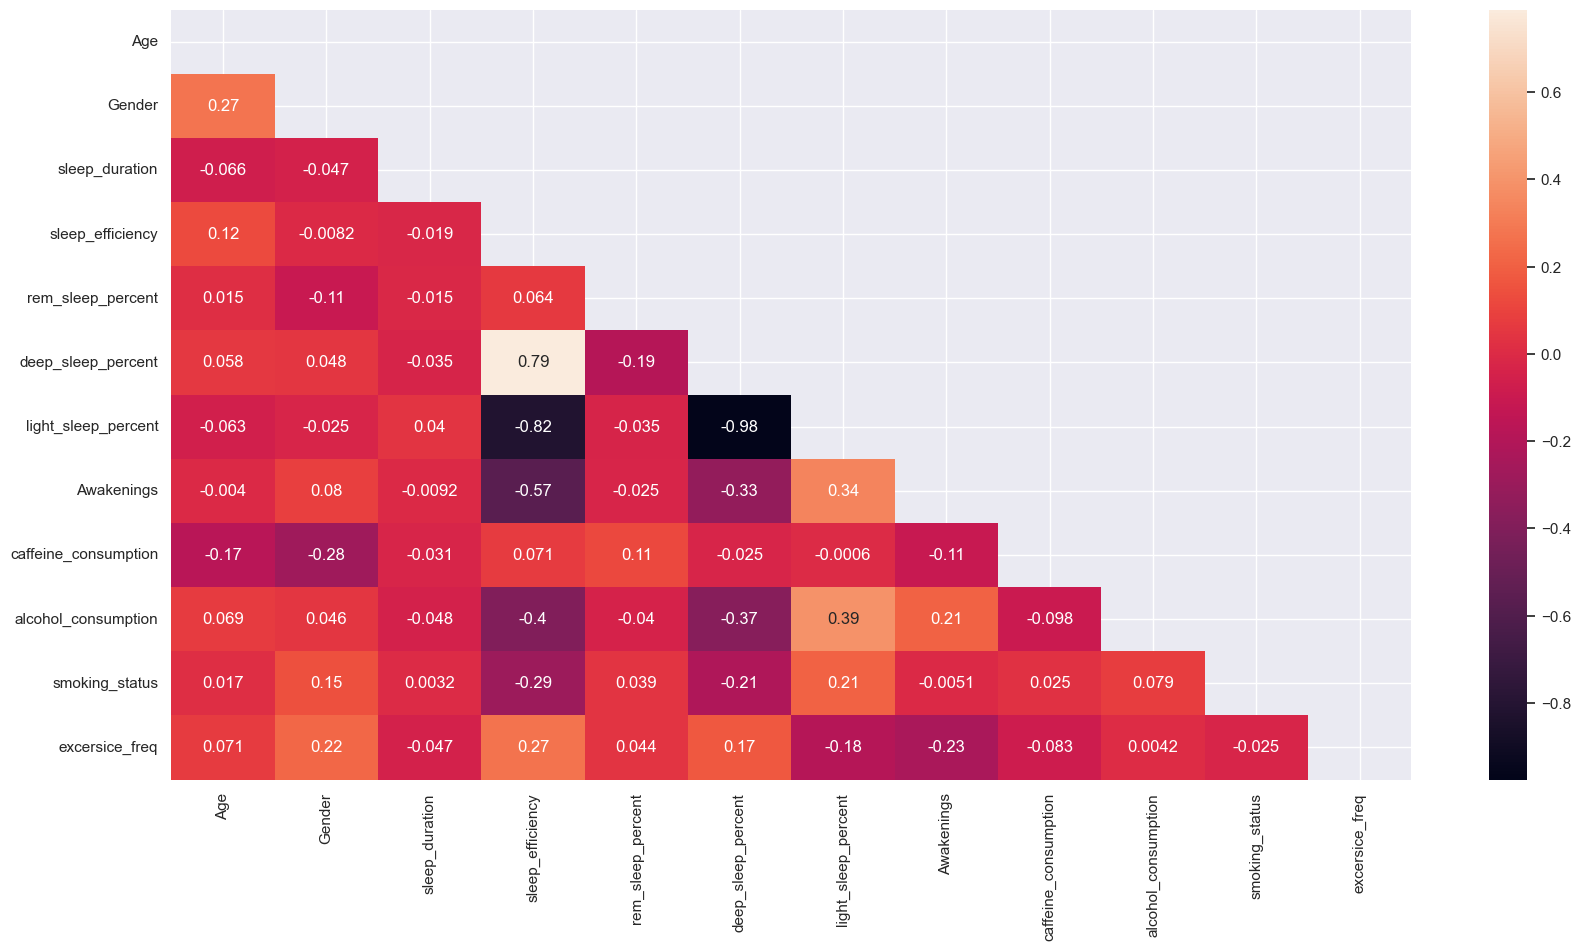

In [134]:
mask = np.zeros_like(data.corr(numeric_only=True))
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(20, 10)})
sns.heatmap(data.corr(numeric_only=True, method='pearson'), annot=True, mask=mask);

#### Kendall

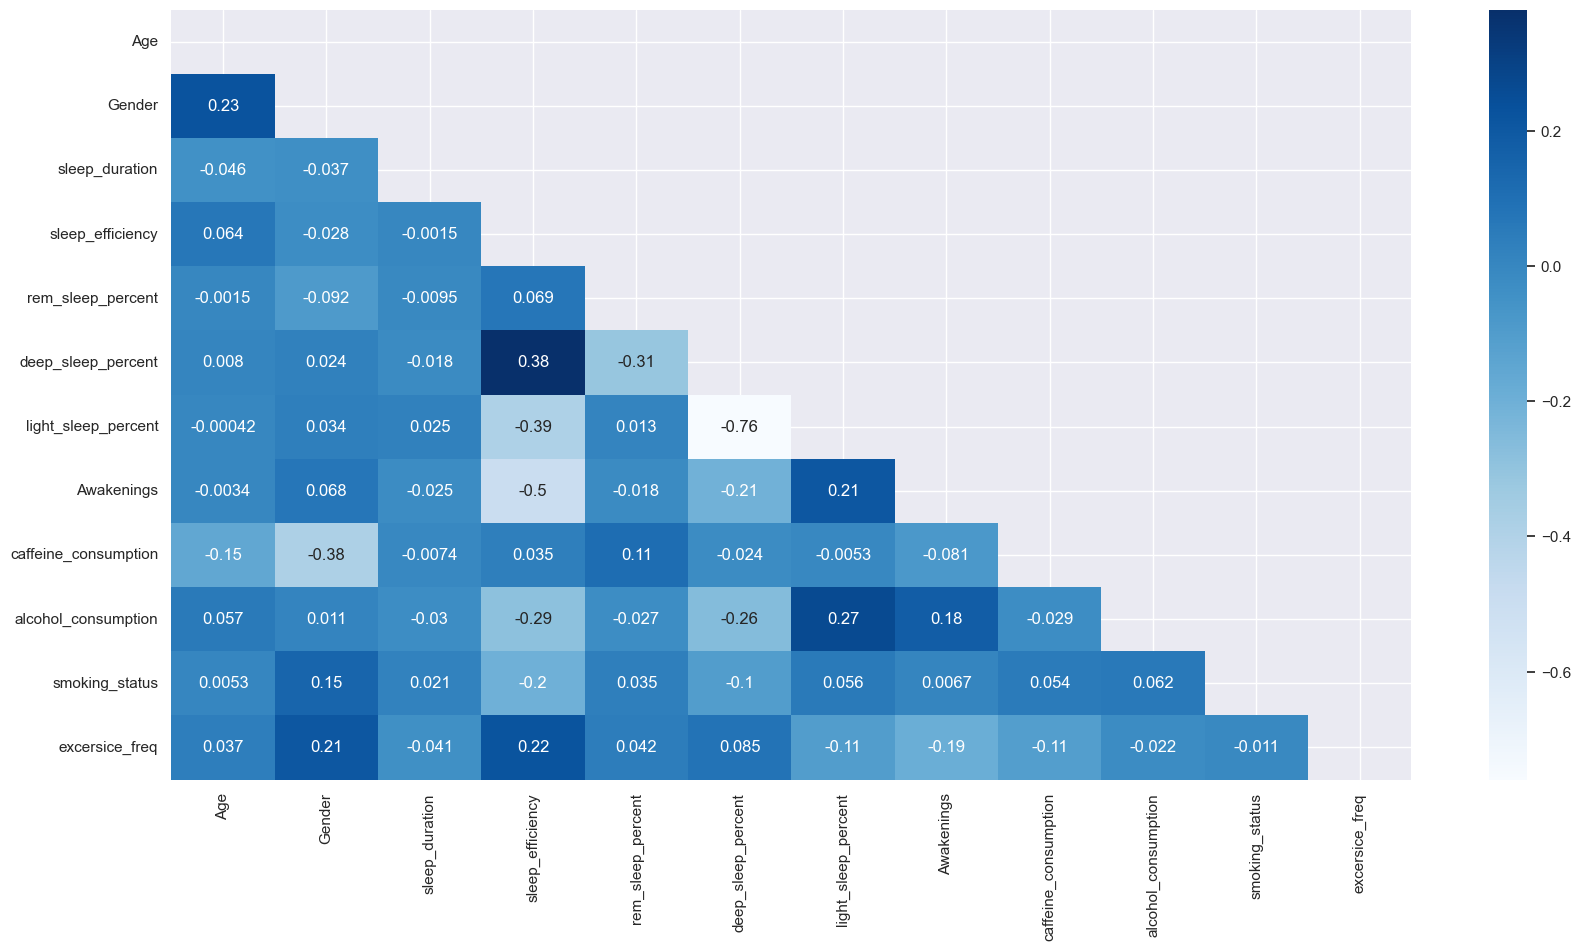

In [135]:
mask = np.zeros_like(data.corr(numeric_only=True))
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(20, 10)})
sns.heatmap(data.corr(numeric_only=True, method='kendall'), annot=True, mask=mask, cmap='Blues');

## Amount of male and female subjects of each age

#### 0 stands for 'Female', 1 stands for 'Male'

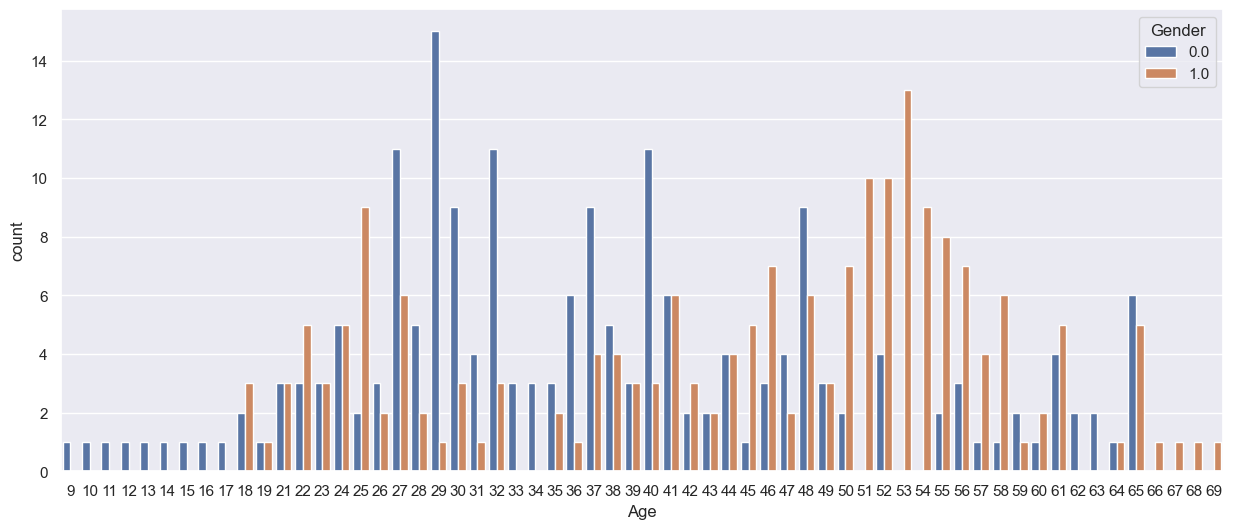

In [136]:
data.Age = data.Age.astype(int)

plt.figure(figsize=(15, 6))
sns.countplot(x='Age', hue='Gender', data=data);

### Sleep efficiency for each gender

In [137]:
data.groupby(['Gender'])['sleep_efficiency'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
0.0,194.0,0.790361,0.141664,0.5,0.68,0.82,0.91,0.98
1.0,194.0,0.788144,0.129833,0.5,0.71,0.82,0.90,0.99


### Lets see dependency between age and sleep efficiency using polynomial regression

Transform 'Age' and 'sleep_efficiency' to polynomial features

In [138]:
X = data[['Age']].to_numpy()
y = data['sleep_efficiency'].to_numpy()

poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

X_plot = np.arange(9, 69, 3).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

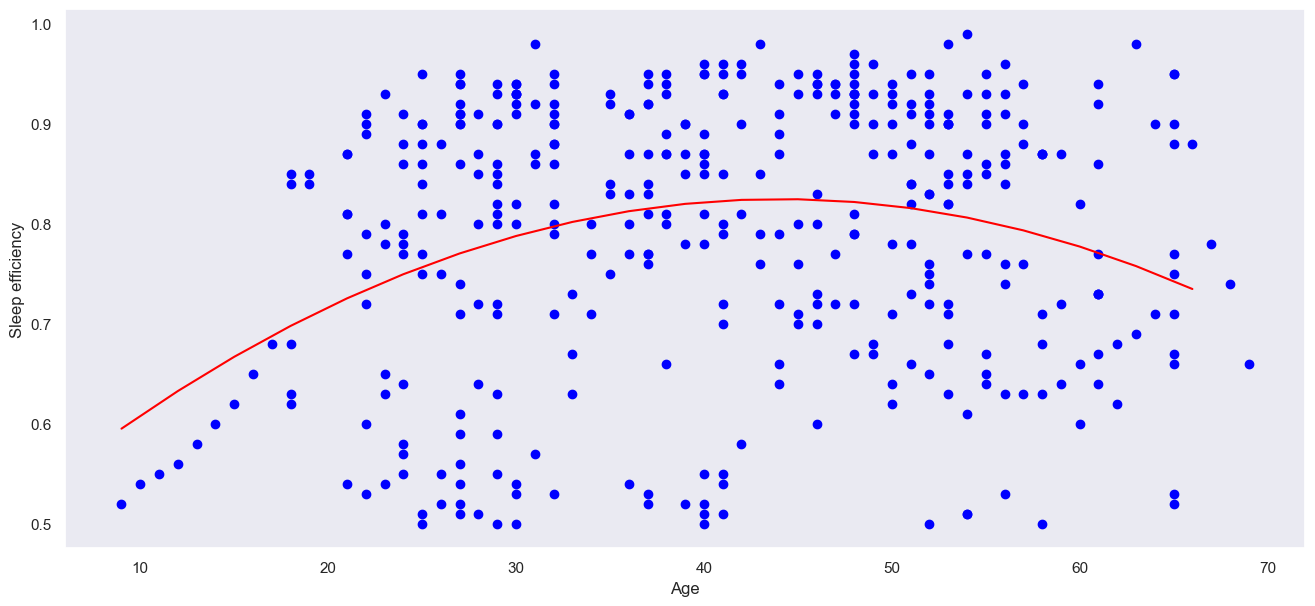

In [139]:
plt.figure(figsize=(16, 7))
plt.scatter(data['Age'], data['sleep_efficiency'], color='blue')
plt.plot(X_plot, y_plot, color='red')

plt.xlabel('Age')
plt.ylabel('Sleep efficiency')

plt.grid()
plt.show()

### Build histograms for each feature

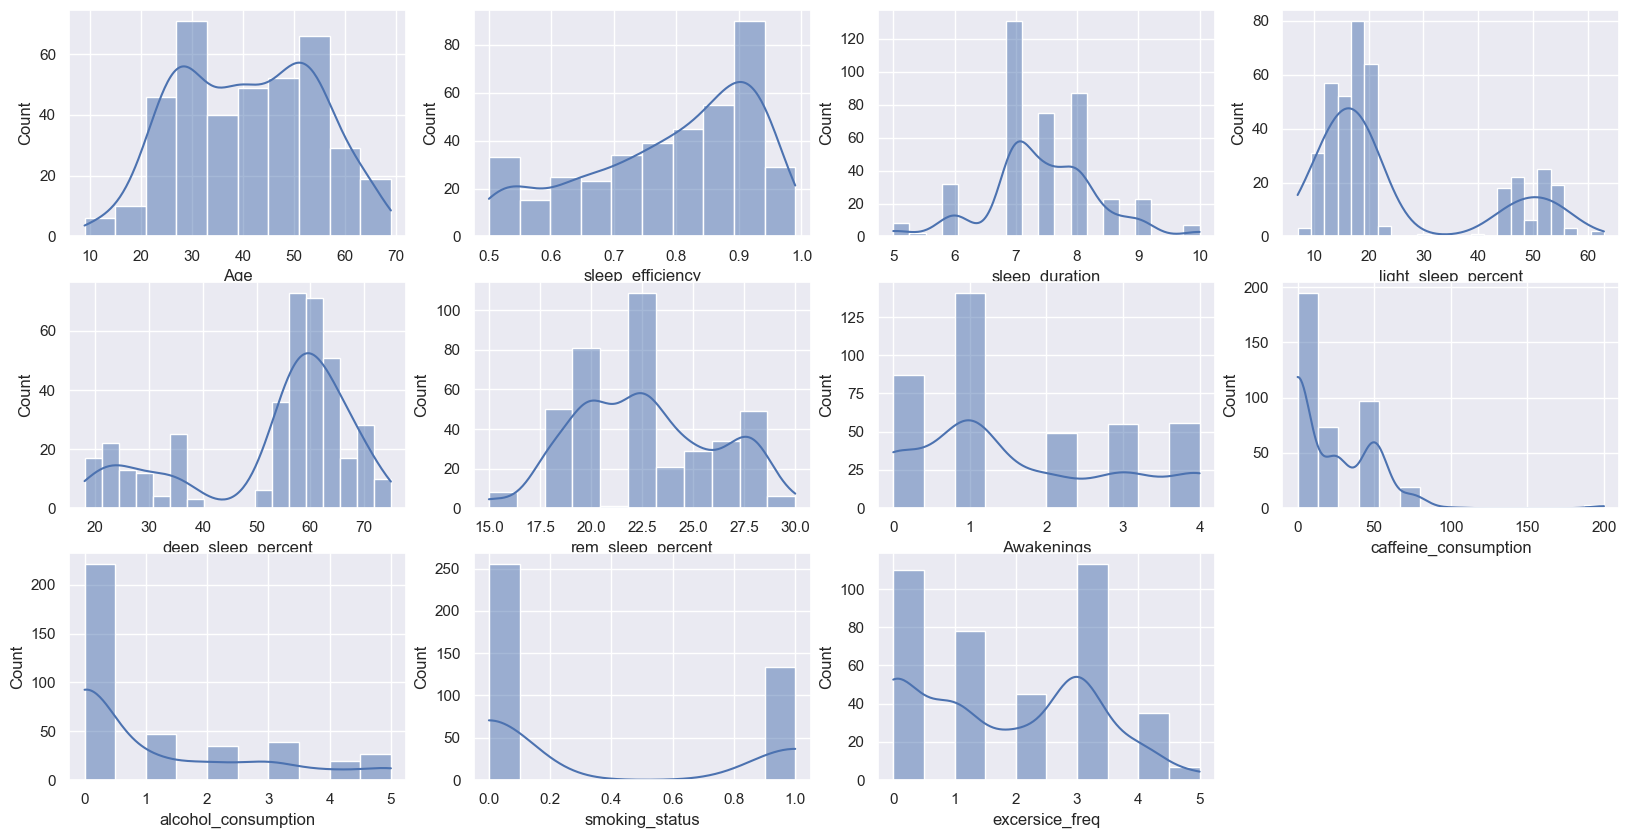

In [140]:
subplot_name = ['Age', 'sleep_efficiency', 'sleep_duration', 'light_sleep_percent', 'deep_sleep_percent',
                'rem_sleep_percent', 'Awakenings', 'caffeine_consumption', 'alcohol_consumption',
                'smoking_status', 'excersice_freq']

n = 1
indx = 0

plt.figure(figsize=(20, 10))

for i in range(11):
    plt.subplot(3, 4, n)
    sns.histplot(x=data[subplot_name[indx]], kde = True);
    
    n += 1
    indx += 1

### As we can see most of the subjects avoid smoking at all.
### Mean excersice frequency is about 1 time a week.
### 'Sleep efficiency' and 'Deep sleep percentage' are skewed to the left.

#  

## Hypothesis checking

In [155]:
def compareVariances(*samples):
    _, p = levene(*samples)
    print(f"Variances are not the same, p-value: {p}") if p < 0.05 else print(f"Variances are the same, p-value: {p}")

In [156]:
def checkNormality(data):
    sampled = [np.random.choice(data, 50) for _ in range(50)]
    means = [np.mean(sampled[i]) for i in range(50)]
    _, p = shapiro(means)
    print(f'Data is not normally distributed, p-value: {p}') if p <= 0.05 else print(f'Data is normally distributed, p-value: {p}')



### Hypothesis 1

#### Does excercising affect your quality of sleep?

#### H0: Yes, it does || H1: No, it doesn't

Let's categorize exercise frequency as 'never', 'sometimes' and 'frequently'

In [157]:
def categorizeFrequency(value):
    if value == 0: 
        return 'never'
    elif value in range(1, 2):
        return 'sometimes'
    elif value >= 3:
        return 'freq'

In [158]:
data['frequency'] = data['excersice_freq'].apply(categorizeFrequency)

display(data)

,Age,Gender,sleep_duration,sleep_efficiency,rem_sleep_percent,deep_sleep_percent,light_sleep_percent,Awakenings,caffeine_consumption,alcohol_consumption,smoking_status,excersice_freq,frequency
0,65,0.0,6.0,0.88,18.0,70.0,12.0,0.0,0.0,0.0,1.0,3.0,freq
1,69,1.0,7.0,0.66,19.0,28.0,53.0,3.0,0.0,3.0,1.0,3.0,freq
2,40,0.0,8.0,0.89,20.0,70.0,10.0,1.0,0.0,0.0,0.0,3.0,freq
3,40,0.0,6.0,0.51,23.0,25.0,52.0,3.0,50.0,5.0,1.0,1.0,sometimes
4,57,1.0,8.0,0.76,27.0,55.0,18.0,3.0,0.0,3.0,0.0,3.0,freq
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,30,0.0,7.5,0.53,28.0,20.0,52.0,4.0,50.0,2.0,1.0,1.0,sometimes
447,27,0.0,7.5,0.91,22.0,57.0,21.0,0.0,0.0,0.0,0.0,5.0,freq
448,52,1.0,6.0,0.74,28.0,57.0,15.0,4.0,25.0,0.0,0.0,3.0,freq
450,45,1.0,7.0,0.76,18.0,72.0,10.0,3.0,0.0,0.0,0.0,3.0,freq


In [159]:
never = data[data['frequency'] == 'never']
sometimes = data[data['frequency'] == 'sometimes']
freq = data[data['frequency'] == 'freq']

categorized_data = [never, sometimes, freq]

In [160]:
for i in range(3):
    checkNormality(categorized_data[i]['sleep_efficiency'])

Data is normally distributed, p-value: 0.8108389051506475
Data is normally distributed, p-value: 0.29223130028057925
Data is normally distributed, p-value: 0.6835692908968221


All sleep efficiency for each category is normally distributed

In [161]:
compareVariances(never.sleep_efficiency, sometimes.sleep_efficiency, freq.sleep_efficiency)

Variances are the same, p-value: 0.5022322982434873


In [162]:
stat, p = f_oneway(never.sleep_efficiency, sometimes.sleep_efficiency, freq.sleep_efficiency)
print(f'Test statistic: {stat}. p-value: {p}');

Test statistic: 11.062205379146015. p-value: 2.2161014397863642e-05


#### p-value is a lot less than 0.05 => let's see which group differs

In [151]:
posthoc_df = posthoc_dunn([never.sleep_efficiency, sometimes.sleep_efficiency, freq.sleep_efficiency], p_adjust='holm')
posthoc_df.columns = ['never', 'sometimes', 'freq']
posthoc_df.index = ['never', 'sometimes', 'freq']
posthoc_df

,never,sometimes,freq
never,1.000000,0.199327,0.000004
sometimes,0.199327,1.000000,0.005888
freq,0.000004,0.005888,1.000000


#### As we can see 'never' and 'frequent' groups differ the most therefore we can say that lack of excercising can affect worse sleep quality

# 

### Hypothesis 2